<a href="https://colab.research.google.com/github/shailavij/NLP/blob/master/Multiclass_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from matplotlib import pyplot as plt
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
#import plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [1]:
pip install -U nltk

Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.5)


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
pip install plotly

In [5]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pwd

In [6]:
%cd /content/drive/My Drive/DL_DATASet/


/content/drive/My Drive/DL_DATASet


In [ ]:
!pwd

In [7]:
df=pd.read_csv("consumer_complaints.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.



In [8]:
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [10]:
df.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id'],
      dtype='object')

In [11]:
df['product'].value_counts()



Mortgage                   186475
Debt collection            101052
Credit reporting            91854
Credit card                 66468
Bank account or service     62563
Consumer Loan               20990
Student loan                15839
Payday loan                  3877
Money transfers              3812
Prepaid card                 2470
Other financial service       557
Name: product, dtype: int64

# Label consolidation
df.loc[df['product'] == 'Credit reporting', 'Product'] = "Credit reporting, credit repair services, or other personal consumer reports"
df.loc[df['product'] == 'Credit card', 'Product'] = "Credit card or prepaid card"
df.loc[df['product'] == 'Payday loan', 'Product'] = "Payday loan, title loan, or personal loan"
df.loc[df['product'] == 'Virtual currency', 'Product'] = "Money transfer, virtual currency, or money service"
df = df[df.product != "Other financial service"]


In [12]:
x=df['product'].value_counts().sort_values(ascending=False)
x

Mortgage                   186475
Debt collection            101052
Credit reporting            91854
Credit card                 66468
Bank account or service     62563
Consumer Loan               20990
Student loan                15839
Payday loan                  3877
Money transfers              3812
Prepaid card                 2470
Other financial service       557
Name: product, dtype: int64

(array([186475.,  91854.,  15839., 101052.,  66468.,  62563.,  20990.,
          3812.,   3877.,   3027.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

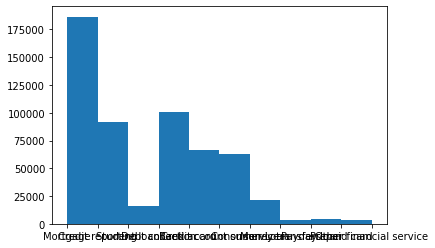

In [13]:
plt.hist(df['product'],bins=10,align='mid')

In [14]:
#Text_Preprocessing
def print_plot(index):
    example = df[df.index == index][['consumer_complaint_narrative', 'product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])


In [15]:
print_plot(304607)

It was brought to my attention that a " Negative ( Not more than two payments past due ) '' was added to my report from Wells Fargo DLR SVC. Wells Fargo has not reported correct information on this auto loan account. First, I am only the co-signor on the account and my friend has not missed any payments in the past 30 days in any month. This past month she was in the hospital, but made an online pay well before the required date for this to be reported. Wells Fargo did not process her payment for over a week causing the payment to go late. This was either incompetence or intentionally done on their part. As a result, my credit score dropped XXXX points and XXXX 's dropped about XXXX points. I want Wells Fargo to amend their report to any credit bureau that they reported ASAP. Also, XXXX has been paying this auto on time for the past 3 years. 

Product: Consumer Loan


In [16]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))



In [17]:
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    #text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [18]:

corp=[]
corp=  clean_text("12 My name is Sita. Living in UK")
print(corp)

name sita living uk


In [19]:
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].astype("str")

In [20]:
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(clean_text)

In [21]:
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].str.replace('\d+', '')

In [22]:
print_plot(304607)

brought attention negative two payments past due added report wells fargo dlr svc wells fargo reported correct information auto loan account first co signor account friend missed payments past days month past month hospital made online pay well required date reported wells fargo process payment week causing payment go late either incompetence intentionally done part result credit score dropped points dropped points want wells fargo amend report credit bureau reported asap also paying auto time past years
Product: Consumer Loan


In [23]:
print_plot(310548)

aside predatory lending company inflated interested rates navient disabled account made impossible log back called multiple times trying resolve refuse help absolutely access account pay nobody customer service help also submitted complaints via email social media also call day night disrupting work day upsetting employer call night sleeping holidays relentless missed calls minutes
Product: Student loan


# LSTM _Modelling
Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.

Limit the data set to the top 5,0000 words.
Set the max number of words in each complaint at 250

In [24]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['consumer_complaint_narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 49393 unique tokens.


In [25]:
#Truncate and pad the input sequences so that they are all in the same length for modeling
X = tokenizer.texts_to_sequences(df['consumer_complaint_narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (555957, 200)


In [26]:
Y = pd.get_dummies(df['product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (555957, 11)


In [27]:

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(500361, 200) (500361, 11)
(55596, 200) (55596, 11)


# Keras_LSTM Architecture
The first layer is the embedded layer that uses 100 length vectors to represent each word.

SpatialDropout1D performs variational dropout in NLP models.

The next layer is the LSTM layer with 100 memory units.

The output layer must create 11 output values, one for each class.

Activation function is softmax for multi-class classification.

Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function

In [29]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1111      
Total params: 5,081,511
Trainable params: 5,081,511
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
import tensorflow as tf
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),    # Bidirection  LSTM will double shape eg. 64*2 =128, chk model summary
    tf.keras.layers.Dense(11, activation='softmax'),
    #tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          5000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_2 (Dense)              (None, 11)                2211      
Total params: 5,163,011
Trainable params: 5,163,011
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 5
batch_size = 64

history = model1.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
7037/7037 [==============================] - 2894s 411ms/step - loss: 1.6973 - accuracy: 0.3877 - val_loss: 1.6525 - val_accuracy: 0.4015
Epoch 2/5
7037/7037 [==============================] - 2936s 417ms/step - loss: 1.6292 - accuracy: 0.4093 - val_loss: 1.6267 - val_accuracy: 0.4096
Epoch 3/5
5657/7037 [=======================>......] - ETA: 9:20 - loss: 1.6108 - accuracy: 0.4143

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();


In [ ]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])
